#Задание  
**Цель:**  
получить навыки решения классических задач NLP  

Задание 1: составить словари для классификации по тональности.
Данные для задания — отзывы
на банки, собранные с нескольких сайтов рунета. Отзывы могут быть как положительными

— оценка 5, так и отрицательными — оценка 1.

    Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.

Обучите по коллекции предложений word2vec

    Приведите несколько удачных и неудачных примеров решения стандартных

текстов для word2vec:

    тест на определение ближайших слов
    тест на аналогии (мужчина — король : женщина — королева)
    тест на определение лишнего слова

    Постройте несколько визуализаций:

    TSNE для топ-100 или топ-500 слов и найдите осмысленные кластеры слов
    задайте координаты для нового пространства следующим образом: одна ось описывает отношение «плохо — хорошо», вторая — «медленно — быстро», и найдите координаты названий банков в этих координатах

Задание 2: распространить метку.

    Определите 5–8 позитивных слов (например, быстрый, удобный) и 5–8 негативных слов (например, очередь, медленно). Эти слова будут основной будущего оценочного словаря
    Пусть позитивному классу соответствует метка 1, негативному — -1
    Пометьте выбранные слова в лексическом графе соответствующими метками
    Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе
    На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 — это и есть искомые оценочные слова


In [ ]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
tqdm.pandas()
import nltk
nltk.download('punkt')

In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Задание 1: составить словари для классификации по тональности.

* Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
* Обучите по коллекции предложений word2vec
* Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec:

    тест на определение ближайших слов
    тест на аналогии (мужчина — король : женщина — королева)
    тест на определение лишнего слова

* Постройте несколько визуализаций:

 * TSNE для топ-100 или топ-500 слов и найдите осмысленные кластеры слов
 * задайте координаты для нового пространства следующим образом: одна ось описывает отношение «плохо — хорошо», вторая — «медленно — быстро», и найдите координаты названий банков в этих координатах


In [ ]:
# загрузка данных
responses = []
with bz2.BZ2File('/content/drive/MyDrive/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:09, 2893.43it/s]


In [ ]:
responses[0]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Жалоба',
 'num_comments': 0,
 'bank_license': 'лицензия № 2562',
 'author': 'uhnov1',
 'bank_name': 'Бинбанк',
 'datetime': '2015-06-08 12:50:54',
 'text': 'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удо

In [ ]:
data = pd.DataFrame.from_dict(responses)

In [ ]:
# создание датафрейма из списка словарей
df = pd.DataFrame.from_dict(responses)
df

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,False,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,False,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN
...,...,...,...,...,...,...,...,...,...,...
153494,None,False,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,None,False,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,None,False,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,None,False,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


In [ ]:
df = df.filter(items=['text', 'rating_grade'])
df

,text,rating_grade
0,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN
...,...,...
153494,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   text          153499 non-null  object 
 1   rating_grade  88658 non-null   float64
dtypes: float64(1), object(1)
memory usage: 2.3+ MB


In [ ]:
df.rating_grade.unique()

array([nan,  2.,  1.,  5.,  3.,  4.])

In [ ]:
len(df)-df.rating_grade.value_counts().sum()

64841

In [ ]:
# уберем NaN из rating_grade
df['rating_grade'] = df['rating_grade'].fillna(df['rating_grade'].mode()[0])

In [ ]:
df.rating_grade.unique()

array([1., 2., 5., 3., 4.])

In [ ]:
df

,text,rating_grade
0,Добрый день! Я не являюсь клиентом банка и пор...,1.0
1,Доброго дня! Являюсь держателем зарплатной кар...,1.0
2,Здравствуйте! Дублирую свое заявление от 03.0...,1.0
3,Добрый день!! Я открыл расчетный счет в СберБа...,1.0
4,"04.03.2015 г. взяла кредит в вашем банке, заяв...",1.0
...,...,...
153494,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


#### Разбейте всю коллекцию отзывов на предложения.

In [ ]:
from nltk import tokenize

In [ ]:
sent = tokenize.PunktSentenceTokenizer()

In [ ]:
sentences = []
for text in tqdm(df.text):
    for el in sent.tokenize(text):
        sentences.append(el)
print(sentences)

100%|██████████| 153499/153499 [01:28<00:00, 1737.20it/s]
IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
sentences[0]

'Добрый день!'

In [ ]:
len(sentences)

2665027

#### Лемматизируйте все слова.

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# препроцессинг + лемматизация

mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
words = re.compile("[А-Яа-я]+")

def words_only(text):
    return " ".join(words.findall(text))

def remove_word(text):
    return " ".join([token for token in text.split() if len(token) >= 3])

def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

def lemmatize(text):
    lemmatizer = nltk.WordNetLemmatizer()
    try:
        return  " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    except:
        return " "

def preprocess(text):
    return remove_stopwords(lemmatize(remove_word(words_only(text.lower()))))

In [ ]:
text_lemm = [preprocess(sentence).split() for sentence in tqdm(sentences)]

100%|██████████| 2665027/2665027 [03:56<00:00, 11245.69it/s]


In [ ]:
text_lemm[:3]

#### Обучите по коллекции предложений word2vec

In [ ]:
! pip install gensim==4.3.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 29.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20444 sha256=1a7ccf7da1241c1192fcea76b10ae6f3ba03e825954c82f7421c755584ceb928
  Stored in directory: /root/.cache/pip/wheels/2d/1b/42/88a19f6b3896c2230d5053832f208976cddf70625885201d06
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3529 sha256=493623c16fd79e1191b0f6862ec5d8d428fd9d899cfd1fb60035f5a9b7ee0fe3
  Stored in directory: /root/.cache/pip/wheels/5b/86/8f/7bb7f6472e2c84de7addfc1a5cd7fd647f00d8fb640da9ea9a
Successfully built fst-pso miniful
  Attempting uninstall: gensim
    Found existing installation: gensim 3.8.2
    Uninstalling gensim-3.8.2

In [ ]:
import gensim
from gensim.models import Word2Vec

In [ ]:
# обучение модели
%time model = Word2Vec(text_lemm, workers=4, vector_size=300, min_count=3, window=5, epochs=15)

CPU times: user 32min 57s, sys: 8.13 s, total: 33min 5s
Wall time: 20min 8s


##### Примеры
Приведите несколько удачных и неудачных примеров решения стандартных текстов для word2vec

тест на определение ближайших слов тест на аналогии (мужчина — король : женщина — королева) тест на определение лишнего слова

In [ ]:
display(model.wv.most_similar('банк'))

[('сбербанк', 0.6082661151885986),
 ('сбер', 0.5979740023612976),
 ('ситибанк', 0.5339627265930176),
 ('промсвязьбанк', 0.5298042893409729),
 ('росбанк', 0.5116526484489441),
 ('альфабанк', 0.5104776620864868),
 ('магазин', 0.5104115009307861),
 ('бинбанк', 0.4989553987979889),
 ('собинбанк', 0.46906569600105286),
 ('банкинг', 0.44693276286125183)]

In [ ]:
print(model.wv.most_similar(positive=['евро', 'рубль'], topn=1))
# print(model_en_tweet.wv.most_similar(positive=["dogs", "man"], negative=["dog"], topn=1))

[('долларов', 0.7733635306358337)]


In [ ]:
print(model.wv.most_similar(positive=['ситибанк', 'альфа'], topn=1))

[('мкб', 0.6284162998199463)]


In [ ]:
print(model.wv.doesnt_match("банк договор музыка".split()))

музыка


In [ ]:
print(model.wv.doesnt_match("карты деньги пистолет".split()))


пистолет


In [ ]:
print(model.wv.doesnt_match("карты деньги пистолет".split()))

пистолет


#### Постройте несколько визуализаций:


* TSNE для топ-100 (или топ-500) слов и найдите осмысленные кластеры слов
* задайте координаты для нового пространства следующим образом: одна ось описывает отношение "плохо – хорошо", вторая – "медленно – быстро" и найдите координаты названий банков в этих координатах. Более формально:
берем вектор слова "хорошо", вычитаем из него вектор слова "плохо", получаем новый вектор, который описывает разницу между хорошими и плохими словами. Берем вектор слова "сбербанк" и умножаем его на этот новый вектор – получаем координату по первой оси. Аналогично – для второй оси. Две координаты уже можно нарисовать на плоскости.

In [ ]:
from nltk import FreqDist

In [ ]:
fd = FreqDist() # определение частотности
top_words = []
top_only_words = []
top_words_f =[]

# создание массива с 100 топ-слов
for text in text_lemm:
    fd.update(text)
for i in fd.most_common(100):
    top_words.append(i)
    top_only_words.append(i[0])
    top_words_f.append(i[1])

In [ ]:
top_words_f[0]

551812

In [ ]:
print(len(top_words), '\n')
print(top_only_words[:20])

100 

['банка', 'банк', 'деньги', 'карту', 'карты', 'кредит', 'день', 'банке', 'заявление', 'очень', 'отделение', 'время', 'счет', 'дней', 'года', 'почему', 'рублей', 'карта', 'вопрос', 'смс']


In [ ]:
from sklearn.manifold import TSNE

In [ ]:
top_words_vec = model[top_only_words]
tsne = TSNE(n_components=2, random_state=0)
top_words_tsne = tsne.fit_transform(top_words_vec)

In [ ]:
top_words_tsne.shape

(100, 2)

In [ ]:
import plotly.express as px

In [ ]:
fig = px.scatter(None, x=top_words_tsne[:,0], y=top_words_tsne[:,1],
labels={
"x": "x1",
"y": "x2",
},
opacity=1,
color=top_words_f,
hover_data=[top_only_words]
)

# Изменение цвета фона графика
fig.update_layout(dict(plot_bgcolor = 'white'))

# Обновление линий осей
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
showline=True, linewidth=1, linecolor='black')

fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='lightgrey',
zeroline=True, zerolinewidth=1, zerolinecolor='lightgrey',
showline=True, linewidth=1, linecolor='black')

# Установка названия рисунка
fig.update_layout(title_text="t-SNE для топ-100")

# Обновление размера маркера
fig.update_traces(marker=dict(size=10))


In [ ]:
# https://docs.bokeh.org/en/latest/
from bokeh.models import ColumnDataSource, LabelSet
from bokeh.plotting import figure, show, output_file
from bokeh.io import output_notebook
output_notebook()

p = figure(title="T-SNE для топ-100")

source = ColumnDataSource(
    data=dict(
        x1=top_words_tsne[:,0],
        x2=top_words_tsne[:,1],
        names=top_only_words))

p.scatter(
    x="x1",
    y="x2",
    size=5,
    source=source)

labels = LabelSet(
    x="x1",
    y="x2",
    text="names",
    y_offset=6,
    text_font_size="5pt",
    text_color="#555555",
    source=source,
    text_align='center')

p.add_layout(labels)
show(p)

In [ ]:
!pip3 install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


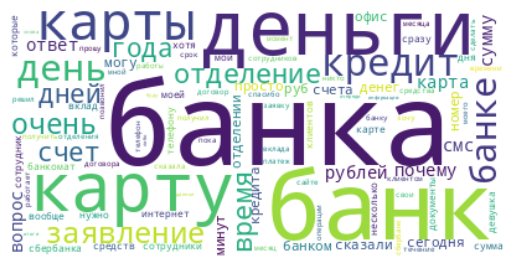

In [ ]:
word_freq = [i for i in top_words]
wd = WordCloud(background_color = 'white')
wd.generate_from_frequencies(dict(word_freq))
plt.figure()
plt.imshow(wd, interpolation = 'bilinear')
plt.axis('off')
plt.show()

In [ ]:
model['хороший']

In [ ]:
good_bad = model['хороший'] - model['плохо']
fast_slow = model['быстро'] - model['медленно']

In [ ]:
good_bad

In [ ]:
data.bank_name.value_counts()

Сбербанк России     26327
Альфа-Банк          10224
ВТБ 24               8185
Русский Стандарт     7943
Хоум Кредит Банк     7549
                    ...  
Сиббизнесбанк           1
Донбанк                 1
Потенциал               1
Ури Банк                1
БайкалИнвестБанк        1
Name: bank_name, Length: 670, dtype: int64

In [ ]:
bank_name=data.bank_name.value_counts(normalize=1).index.tolist()[:15] # топ 15
bank_name=[preprocess(bank.lower()).split()[0] for bank in bank_name ] # предобработка
bank_name

['сбербанк',
 'альфа',
 'втб',
 'русский',
 'хоум',
 'тинькофф',
 'национальный',
 'ренессанс',
 'связной',
 'отп',
 'восточный',
 'райффайзенбанк',
 'московский',
 'ситибанк',
 'авангард']

In [ ]:
bank = pd.DataFrame(bank_name, columns=['bank_name'])

In [ ]:
bank

,bank_name
0,сбербанк
1,альфа
2,втб
3,русский
4,хоум
5,тинькофф
6,национальный
7,ренессанс
8,связной
9,отп


In [ ]:
len(model[bank.bank_name[0]])

300

In [ ]:
# умножение эмбединга с именем банка на вектор с осью
bank['X'] = bank.apply(lambda row:np.dot(model[row['bank_name']], good_bad), axis=1)
bank['Y'] = bank.apply(lambda row:np.dot(model[row['bank_name']], fast_slow), axis=1)

In [ ]:
bank

,bank_name,X,Y
0,сбербанк,-25.679174,16.769817
1,альфа,39.503620,29.999580
2,втб,32.839859,28.570852
3,русский,15.256014,-7.180645
4,хоум,33.950596,22.555475
5,тинькофф,42.508823,26.211437
6,национальный,48.923740,-11.407058
7,ренессанс,21.431061,19.528212
8,связной,49.418167,32.552780
9,отп,28.855459,37.203918


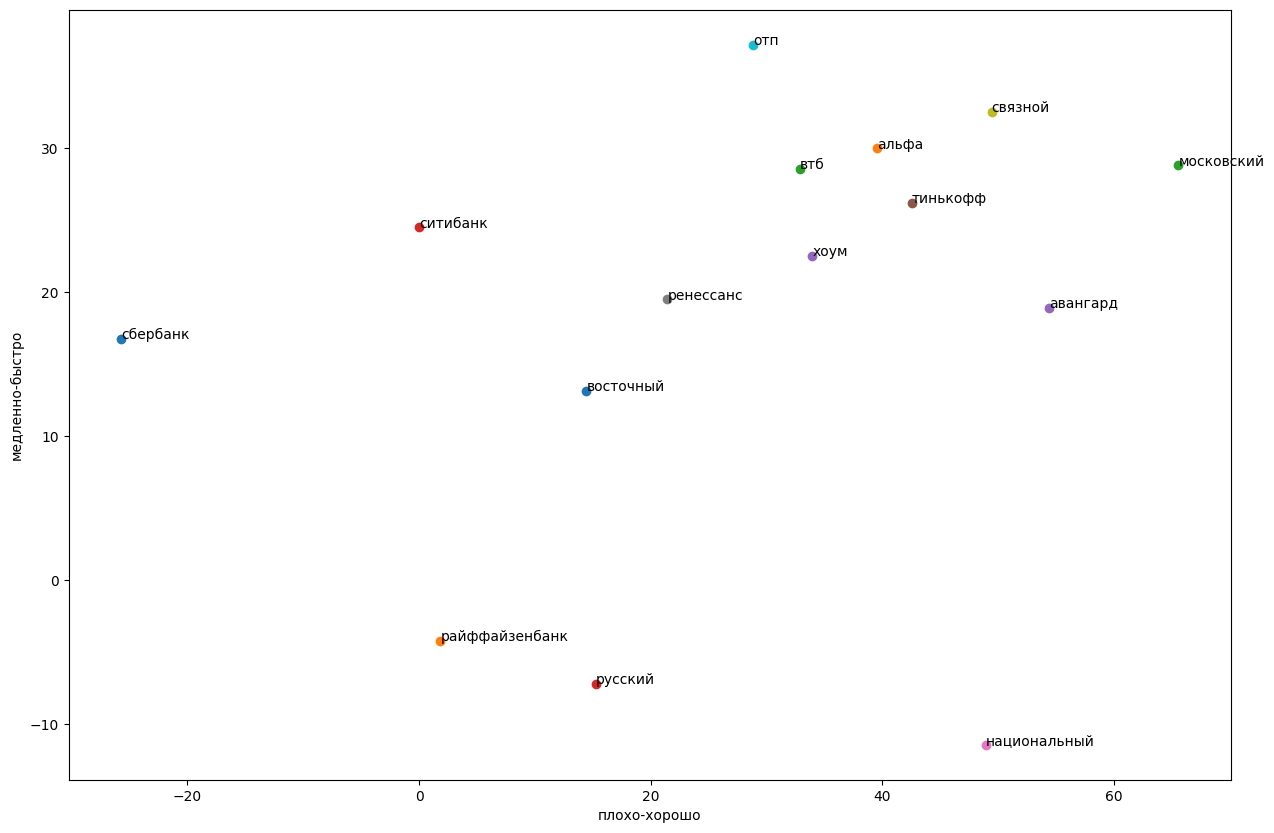

In [ ]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1,1,1)

for i in range(len(bank)):
    x, y, text = bank.iloc[i]['X'], bank.iloc[i]['Y'], bank.iloc[i]['bank_name']
    ax.scatter(x, y)
    ax.text(x, y, text)

ax.set_xlabel('плохо-хорошо')
ax.set_ylabel('медленно-быстро')

plt.show()

In [ ]:
output_notebook()

p = figure(
    tools="pan,wheel_zoom,reset,save",
    toolbar_location="above",
    title="15 самых популярных банков в новых осях")

source = ColumnDataSource(
    data=dict(
        x1=bank.X,
        x2=bank.Y,
        names=bank.bank_name))

p.scatter(x="x1", y="x2", size=10, source=source)

labels = LabelSet(
    x="x1",
    y="x2",
    text="names",
    y_offset=6,
    text_font_size="9pt",
    text_color="#555555",
    source=source,
    text_align='center')

p.add_layout(labels)
p.xaxis.axis_label = 'плохо-хорошо'
p.yaxis.axis_label = 'медленно-быстро'
show(p)

### Задание 2: распространить метку.


Определите 5–8 позитивных слов (например, быстрый, удобный) и 5–8 негативных слов (например, очередь, медленно). Эти слова будут основной будущего оценочного словаря
Пусть позитивному классу соответствует метка 1, негативному — -1
Пометьте выбранные слова в лексическом графе соответствующими метками
Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе
На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 — это и есть искомые оценочные слова


#### Определите 5–8 позитивных слов (например, быстрый, удобный) и 5–8 негативных слов (например, очередь, медленно). Эти слова будут основной будущего оценочного словаря

In [ ]:
print(model.wv.key_to_index)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
from gensim import corpora
#  сохранение извлеченных токенов в словарь
my_dictionary = corpora.Dictionary(text_lemm)
print(my_dictionary)

Dictionary<264430 unique tokens: ['день', 'добрый', 'банка', 'банком', 'договору']...>


In [ ]:
len(my_dictionary)

264430

In [ ]:
model.wv.most_similar(positive=['быстрый', 'удобный'], topn=8)

[('оперативный', 0.6500906348228455),
 ('удобен', 0.6414101719856262),
 ('понятный', 0.6154302358627319),
 ('отличный', 0.6068035364151001),
 ('продуманный', 0.589693009853363),
 ('безопасный', 0.5872557759284973),
 ('комфортный', 0.5850366353988647),
 ('функциональный', 0.5841221809387207)]

In [ ]:
model.wv.most_similar(positive=['очередь', 'медленно'], topn=8)

[('неторопливо', 0.6039108037948608),
 ('толпа', 0.5416073799133301),
 ('неспешно', 0.5391420125961304),
 ('очереди', 0.5356124043464661),
 ('спеша', 0.49790158867836),
 ('толпу', 0.49454960227012634),
 ('народу', 0.49213773012161255),
 ('душно', 0.4871962070465088)]

In [ ]:
pos = {}
poslist = []
for el in model.wv.most_similar(positive=['быстрый', 'удобный'], topn=8):
    poslist.append(el[0])
    for el in poslist:
        pos[el] = '1'
# print(pos)

negative = {}
negativelist = []
for el in model.wv.most_similar(positive=['очередь', 'медленно'], topn=8):
    negativelist.append(el[0])
    for el in negativelist:
        negative[el] = '-1'
# print(negative)

pos.update(negative)
pos

{'оперативный': '1',
 'удобен': '1',
 'понятный': '1',
 'отличный': '1',
 'продуманный': '1',
 'безопасный': '1',
 'комфортный': '1',
 'функциональный': '1',
 'неторопливо': '-1',
 'толпа': '-1',
 'неспешно': '-1',
 'очереди': '-1',
 'спеша': '-1',
 'толпу': '-1',
 'народу': '-1',
 'душно': '-1'}

In [ ]:
pip install python-igraph

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for python-igraph: filename=python_igraph-0.10.4-py3-none-any.whl size=9073 sha256=cbb121e0e77e78823cb8cd0f5ab7426a46a0613b222d4e045186fd9f66586a43
  Stored in directory: /root/.cache/pip/wheels/49/27/15/dcf90953e3e3322e6f3e447514b20cf39b53c6518cb4a7bace
Successfully built python-igraph


In [ ]:
# words = list(model.wv.index_to_key)
# words = list(model.wv.key_to_index.keys())
words = list(pos.keys())

In [ ]:
words = list(model.wv.index_to_key)

In [ ]:
words[:5]

['оперативный', 'удобен', 'понятный', 'отличный', 'продуманный']

In [ ]:
import igraph as ig
g = ig.Graph(directed=True)
for word in words:
    g.add_vertex(word)

for word in words:
    node = g.vs.select(name = word).indices[0]
    similar_words = model.wv.most_similar(word, topn=5)
    for sim in similar_words:
        word1 = sim[0]
        val  = sim[1]
        new_node = g.vs.select(name = word1).indices[0]
        g.add_edge(node, new_node, weight = val)

In [ ]:
from gensim.summarization import keywords

In [ ]:
model.build_vocab

#### Пусть позитивному классу соответствует метка 1, негативному — -1

#### Пометьте выбранные слова в лексическом графе соответствующими метками

#### Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе

#### На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 — это и есть искомые оценочные слова